# <center>Network Extraction

### <center>Original data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import geopandas as gpd
import networkx as nx
from matplotlib.colors import LinearSegmentedColormap, PowerNorm, LogNorm
from scipy.spatial import distance_matrix
from sklearn.cluster import DBSCAN
from pathlib import Path
from tqdm import tqdm
import glob

In [2]:
# dictionary to convert between inconsistencies in port data base and COMTRADE
COUNTRY_NAME_CONVERTER = {'Turkey': 'Türkiye',
                          'Russia': 'Russian Federation'}

In [3]:
# GLOBAL PARAMETERS
AGGREGATION_METHOD = 'kmeans'  # Options: 'none', 'grid', 'kmeans'
GRID_GRANULARITY = 0.1  # Grid cell size in degrees (used when AGGREGATION_METHOD='grid')
KMEANS_N_CLUSTERS = 10000  # Number of clusters for k-means (used when AGGREGATION_METHOD='kmeans')
MIN_VALUE_THRESHOLD = 2  # Minimum density value to include points (reduced due to aggregation)
CONNECTIONS_PER_NODE = 2  # Number of nearest neighbors to connect
SHIPPING_LANE_DECIMAL_PLACES = 2  # Number of decimal places for rounding shipping lane coordinates

# PORT DATA PARAMETERS
WATER_BODIES = ['Mediterranean Sea', 'Black Sea', 'Strait of Gibraltar']  # Water bodies to filter for
HARBOR_SIZES = ['V', 'S', 'M', 'L']  # Harbor sizes to include (V=Very Small, S=Small, M=Medium, L=Large)
ADDITIONAL_PORTS_BY_NAME = ['Tunis', 'Mina Tarabulus (Tripoli)', 'Haifa', 'Bar', 
                            'Sayda', 'Larnaca', 'Constanta', 'Durres', 'Neum', 
                            'Koper', 'Valletta Harbors']  # Manually add specific ports by name, regardless of size

# CHOKE POINTS PARAMETERS
CHOKE_POINTS = [
    {'name': 'Dardanelles', 'lon': 26.670913795551606, 'lat': 40.385990414396176}
]  # Strategic choke points to include in network analysis

In [4]:
# Load all CSV files from density_data folder organized by subfolders
density_data_folder = "../../data/density_data"

# Find all subfolders in density_data
subfolders = [f for f in Path(density_data_folder).iterdir() if f.is_dir()]

print(f"Found {len(subfolders)} subfolders in {density_data_folder}:")
for folder in sorted(subfolders):
    print(f"  - {folder.name}")

# Process each subfolder separately
all_folder_data = []

for subfolder in tqdm(sorted(subfolders), desc="Processing subfolders"):
    # Get all CSV files in this subfolder
    csv_files = list(subfolder.glob("*.csv"))
    
    print(f"\n{subfolder.name}: Found {len(csv_files)} CSV files")
    
    # Load all CSV files from this subfolder
    monthly_data = []
    for csv_file in csv_files:
        df = pd.read_csv(csv_file)
        monthly_data.append(df)
    
    # Concatenate all monthly data
    folder_combined = pd.concat(monthly_data, ignore_index=True)
    print(f"  Total rows: {len(folder_combined)}")
    
    # Aggregate by 'center' column (sum values for same location across months)
    folder_aggregated = folder_combined.groupby('center', as_index=False).agg({
        'band': 'first',  # Keep first band value
        'value': 'sum',   # Sum values across months
        'rect': 'first'   # Keep first rect value
    })
    
    print(f"  After aggregating by location: {len(folder_aggregated)} unique points")
    print(f"  Value range: {folder_aggregated['value'].min():.2f} to {folder_aggregated['value'].max():.2f}")
    
    all_folder_data.append(folder_aggregated)

# Concatenate all folder data
print(f"\n{'='*60}")
print("Combining data from all subfolders...")
combined_data = pd.concat(all_folder_data, ignore_index=True)
print(f"Total rows before cross-folder deduplication: {len(combined_data)}")

# Remove duplicates across folders based on 'center' column (keep first occurrence)
combined_data = combined_data.drop_duplicates(subset=['center'], keep='first')
print(f"Total rows after cross-folder deduplication: {len(combined_data)}")
print(f"Duplicates removed: {len(pd.concat(all_folder_data, ignore_index=True)) - len(combined_data)}")

Found 7 subfolders in ../../data/density_data:
  - GMTDS 2023-2024 20 Meters (1)
  - GMTDS 2023-2024 20 Meters (3)
  - GMTDS 2023-2024 20 Meters (4)
  - GMTDS 2023-2024 20 meters
  - GMTDS 2023-2024 20 meters (2)
  - GMTDS 2023-2024 20 meters (5)
  - GMTDS 2023-2024 20 meters (6)


Processing subfolders:   0%|          | 0/7 [00:00<?, ?it/s]


GMTDS 2023-2024 20 Meters (1): Found 12 CSV files


Processing subfolders:  14%|█▍        | 1/7 [00:00<00:01,  3.48it/s]

  Total rows: 133510
  After aggregating by location: 53988 unique points
  Value range: 0.00 to 9370.82

GMTDS 2023-2024 20 Meters (3): Found 12 CSV files
  Total rows: 1219515


Processing subfolders:  29%|██▊       | 2/7 [00:03<00:09,  1.92s/it]

  After aggregating by location: 339105 unique points
  Value range: 0.00 to 3236.50

GMTDS 2023-2024 20 Meters (4): Found 12 CSV files
  Total rows: 852532


Processing subfolders:  43%|████▎     | 3/7 [00:05<00:07,  1.95s/it]

  After aggregating by location: 261667 unique points
  Value range: 0.00 to 4431.96

GMTDS 2023-2024 20 meters: Found 12 CSV files
  Total rows: 1157525


Processing subfolders:  57%|█████▋    | 4/7 [00:08<00:07,  2.34s/it]

  After aggregating by location: 258284 unique points
  Value range: 0.00 to 6376.49

GMTDS 2023-2024 20 meters (2): Found 12 CSV files
  Total rows: 765329


Processing subfolders:  71%|███████▏  | 5/7 [00:10<00:04,  2.16s/it]

  After aggregating by location: 190104 unique points
  Value range: 0.00 to 13799.97

GMTDS 2023-2024 20 meters (5): Found 12 CSV files


Processing subfolders:  86%|████████▌ | 6/7 [00:10<00:01,  1.67s/it]/var/folders/3d/fbytqdpn2m599fcr4p1zr9_h0000gn/T/ipykernel_76066/355999197.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  folder_combined = pd.concat(monthly_data, ignore_index=True)
Processing subfolders: 100%|██████████| 7/7 [00:10<00:00,  1.55s/it]

  Total rows: 311540
  After aggregating by location: 104761 unique points
  Value range: 0.00 to 3017.95

GMTDS 2023-2024 20 meters (6): Found 12 CSV files
  Total rows: 460
  After aggregating by location: 375 unique points
  Value range: 0.00 to 217.54

Combining data from all subfolders...
Total rows before cross-folder deduplication: 1208284


Total rows after cross-folder deduplication: 1193945
Duplicates removed: 14339


In [5]:
# Display the combined data
combined_data

center     band     value  \
0        POINT (10.0034517060098 41.6173747306415)  DEFAULT  1.182268   
1         POINT (10.0034517060098 41.626418422862)  DEFAULT  2.624271   
2        POINT (10.0034517060098 41.6535494995234)  DEFAULT  0.012703   
3        POINT (10.0034517060098 41.6625931917439)  DEFAULT  0.039028   
4        POINT (10.0034517060098 41.6716368839644)  DEFAULT  0.039094   
...                                            ...      ...       ...   
1208279   POINT (39.485888344749 43.5436811736021)  DEFAULT  0.274083   
1208280  POINT (41.6563744776623 41.6625931917439)  DEFAULT  3.106286   
1208281  POINT (41.6563744776623 41.6716368839644)  DEFAULT  0.634640   
1208282  POINT (41.6654181698828 41.6716368839644)  DEFAULT  0.109449   
1208283  POINT (41.6654181698828 41.6806805761848)  DEFAULT  1.038543   

                                                      rect  
0        MULTIPOLYGON(((9.99892985989955 41.61285288453...  
1        MULTIPOLYGON(((9.99892985989955 41.62189657675...  
2        MULTIPOLYGON(((9.99892985989955 41.64902765341...  
3        MULTIPOLYGON(((9.99892985989955 41.65807134563...  
4        MULTIPOLYGON(((9.99892985989955 41.66711503785...  
...                                                    ...  
1208279  MULTIPOLYGON(((39.4813664986388 43.53915932749...  
1208280  MULTIPOLYGON(((41.6518526315521 41.65807134563...  
1208281  MULTIPOLYGON(((41.6518526315521 41.66711503785...  
1208282  MULTIPOLYGON(((41.6608963237726 41.66711503785...  
1208283  MULTIPOLYGON(((41.6608963237726 41.67615873007...  

[1193945 rows x 4 columns]

In [6]:
# Extract coordinates from combined data
print("Extracting coordinates from combined data...")
combined_data['lon'] = combined_data['center'].str.extract(r'POINT \(([^ ]+)')[0].astype(float)
combined_data['lat'] = combined_data['center'].str.extract(r'POINT \([^ ]+ ([^)]+)\)')[0].astype(float)

print(f"Coordinate range:")
print(f"  Longitude: {combined_data['lon'].min():.2f} to {combined_data['lon'].max():.2f}")
print(f"  Latitude: {combined_data['lat'].min():.2f} to {combined_data['lat'].max():.2f}")

Extracting coordinates from combined data...
Coordinate range:
  Longitude: -5.32 to 41.67
  Latitude: 30.44 to 47.13


In [7]:
# Store original data extent for consistent map boundaries across all visualizations
ORIGINAL_LON_MIN = combined_data['lon'].min()
ORIGINAL_LON_MAX = combined_data['lon'].max()
ORIGINAL_LAT_MIN = combined_data['lat'].min()
ORIGINAL_LAT_MAX = combined_data['lat'].max()

print(f"Original data extent (will be used for all maps):")
print(f"  Longitude: {ORIGINAL_LON_MIN:.2f} to {ORIGINAL_LON_MAX:.2f}")
print(f"  Latitude: {ORIGINAL_LAT_MIN:.2f} to {ORIGINAL_LAT_MAX:.2f}")

Original data extent (will be used for all maps):
  Longitude: -5.32 to 41.67
  Latitude: 30.44 to 47.13


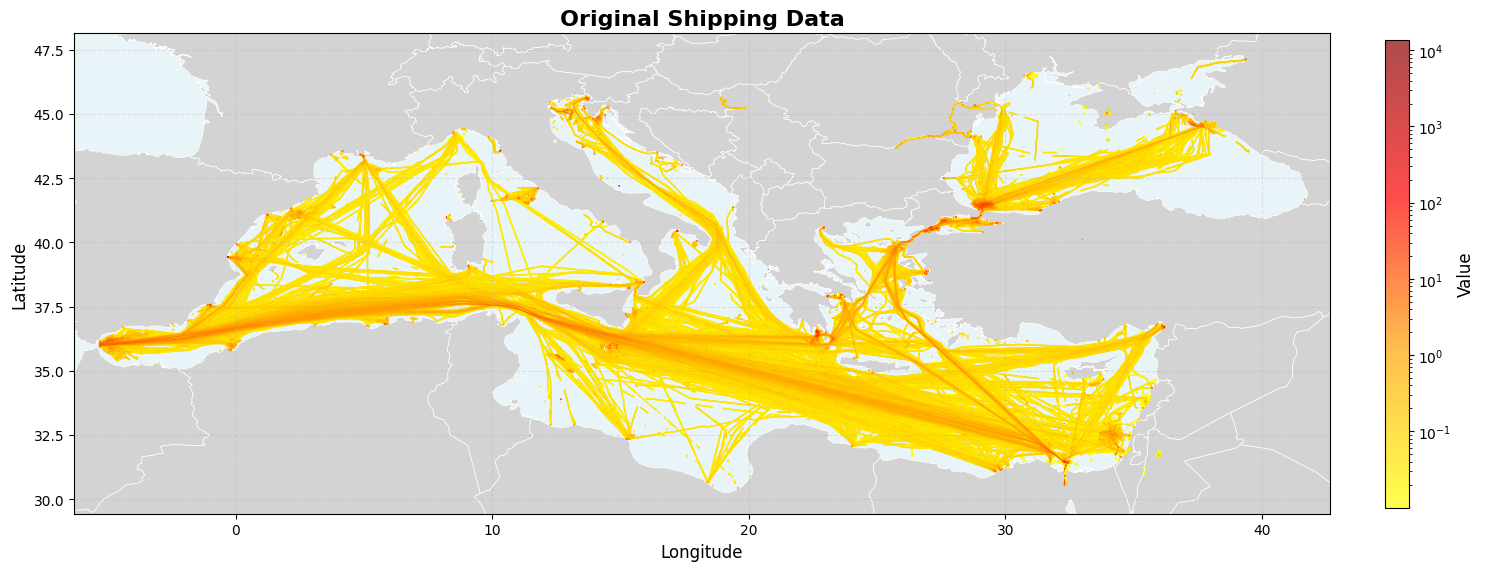


Visualization complete!
Total points plotted: 1193945
Log-scale normalization applied


In [8]:
# Load higher resolution world map (1:10m scale)
world = gpd.read_file('https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip')

# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 12))

# Plot the world map as background
world.plot(ax=ax, color='lightgray', edgecolor='white', linewidth=0.5)

# Set map extent based on data bounds (with padding)
lon_min, lon_max = ORIGINAL_LON_MIN - 1, ORIGINAL_LON_MAX + 1
lat_min, lat_max = ORIGINAL_LAT_MIN - 1, ORIGINAL_LAT_MAX + 1
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

# Create yellow-to-dark-red colormap
colors = ['yellow', 'orange', 'red', 'darkred']
n_bins = 100
cmap = LinearSegmentedColormap.from_list('yellow_darkred', colors, N=n_bins)

# Use LogNorm for log-scale color mapping
norm = LogNorm(vmin=combined_data['value'].min()+0.01, vmax=combined_data['value'].max())

# Create scatter plot with value-based coloring and much smaller points
scatter = ax.scatter(combined_data['lon'], 
                     combined_data['lat'], 
                     c=combined_data['value'],
                     cmap=cmap,
                     norm=norm,
                     s=1,  # Much smaller size
                     alpha=0.7,
                     edgecolors='none')

# Add colorbar with full height
cbar = plt.colorbar(scatter, ax=ax, label='Value', fraction=0.046, pad=0.04, 
                    shrink=0.4)
cbar.set_label('Value', fontsize=12)

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.3)

# Labels and title
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title('Original Shipping Data', 
             fontsize=16, fontweight='bold')

# Set background color
ax.set_facecolor('#E8F4F8')

plt.tight_layout()
plt.show()

print(f"\nVisualization complete!")
print(f"Total points plotted: {len(combined_data)}")
print(f"Log-scale normalization applied")

In [9]:
# Aggregate data using selected method
print(f"AGGREGATION_METHOD: {AGGREGATION_METHOD}")

if AGGREGATION_METHOD == 'none':
    print("No aggregation - using all data points directly")
    aggregated_data = combined_data[['lon', 'lat', 'value']].copy()
    print(f"Using {len(aggregated_data)} data points")
    
elif AGGREGATION_METHOD == 'grid':
    print(f"Grid aggregation with granularity: {GRID_GRANULARITY}°")
    # Assign each point to a grid cell by rounding coordinates
    combined_data['grid_lon'] = (combined_data['lon'] / GRID_GRANULARITY).round() * GRID_GRANULARITY
    combined_data['grid_lat'] = (combined_data['lat'] / GRID_GRANULARITY).round() * GRID_GRANULARITY
    
    # Group by grid cell and sum the values
    aggregated_data = combined_data.groupby(['grid_lon', 'grid_lat'], as_index=False).agg({
        'value': 'sum'
    })
    aggregated_data.rename(columns={'grid_lon': 'lon', 'grid_lat': 'lat'}, inplace=True)
    
    print(f"Original: {len(combined_data)} points")
    print(f"Aggregated: {len(aggregated_data)} grid cells")
    print(f"Reduction: {len(combined_data) - len(aggregated_data)} points merged")
    
elif AGGREGATION_METHOD == 'kmeans':
    print(f"K-Means clustering with {KMEANS_N_CLUSTERS} clusters")
    
    from sklearn.cluster import MiniBatchKMeans
    
    coords = combined_data[['lon', 'lat']].values
    values = combined_data['value'].values
    
    # Use MiniBatchKMeans for efficiency with large datasets
    print("Running MiniBatchKMeans clustering...")
    kmeans = MiniBatchKMeans(n_clusters=KMEANS_N_CLUSTERS, random_state=42, 
                            batch_size=10000, n_init=3, verbose=0)
    labels = kmeans.fit_predict(coords)
    
    # Aggregate by cluster
    cluster_data = []
    for cluster_id in tqdm(range(KMEANS_N_CLUSTERS), desc="Aggregating clusters"):
        mask = labels == cluster_id
        if mask.sum() == 0:
            continue
            
        cluster_values = values[mask]
        total_value = cluster_values.sum()
        
        # Use cluster center from k-means
        centroid_lon, centroid_lat = kmeans.cluster_centers_[cluster_id]
        
        cluster_data.append({
            'lon': centroid_lon,
            'lat': centroid_lat,
            'value': total_value,
            'cluster_size': mask.sum()
        })
    
    aggregated_data = pd.DataFrame(cluster_data)
    
    print(f"Original: {len(combined_data)} points")
    print(f"Aggregated: {len(aggregated_data)} clusters")
    print(f"Reduction: {(1 - len(aggregated_data)/len(combined_data))*100:.1f}%")
    print(f"Average cluster size: {aggregated_data['cluster_size'].mean():.1f} points")

else:
    raise ValueError(f"Unknown AGGREGATION_METHOD: {AGGREGATION_METHOD}. Use 'none', 'grid', or 'kmeans'.")

print(f"\nValue range: {aggregated_data['value'].min():.2f} to {aggregated_data['value'].max():.2f}")
aggregated_data.head()

AGGREGATION_METHOD: kmeans
K-Means clustering with 10000 clusters
Running MiniBatchKMeans clustering...


Aggregating clusters: 100%|██████████| 10000/10000 [00:07<00:00, 1269.36it/s]


Original: 1193945 points
Aggregated: 10000 clusters
Reduction: 99.2%
Average cluster size: 119.4 points

Value range: 0.06 to 16328.31


lon        lat       value  cluster_size
0  14.468739  36.419089  248.912465           104
1  25.264068  38.759010   19.427025            97
2   3.209140  37.090045  209.921437           157
3  30.014128  34.432672    7.010571           140
4  33.141257  43.277352    7.408989           160

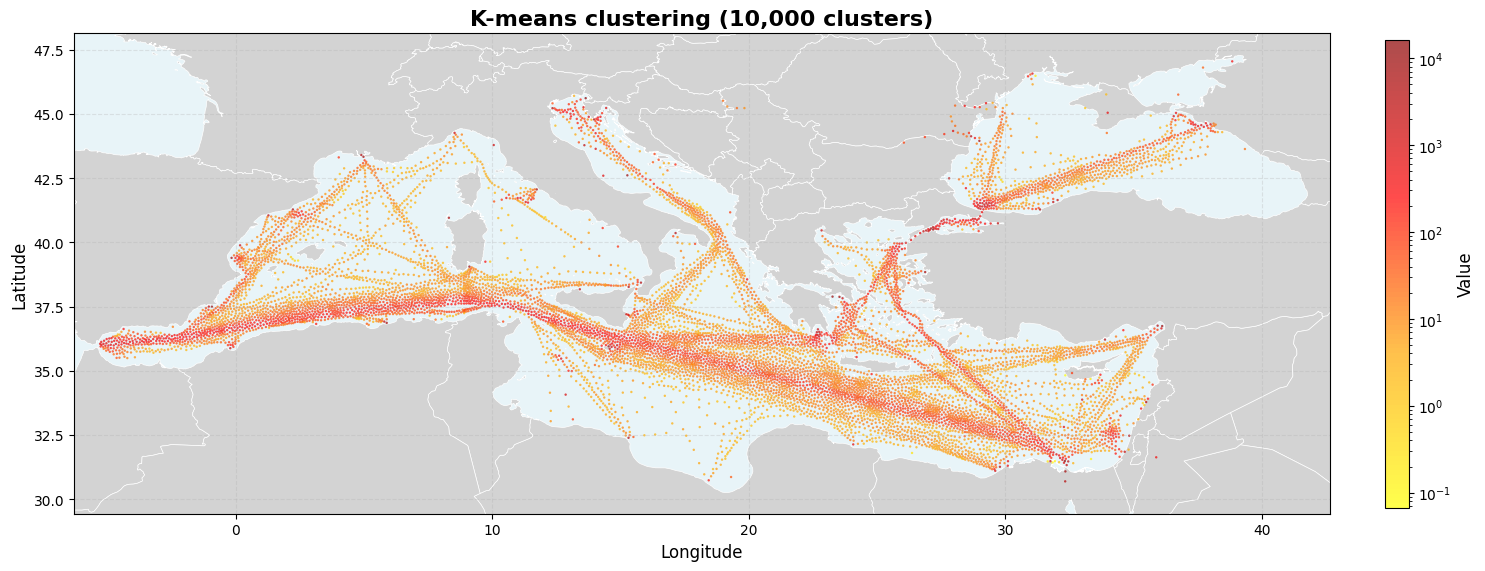


Visualization complete!
Total points plotted: 10000
Log-scale normalization applied


In [10]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 12))

# Plot the world map as background
world.plot(ax=ax, color='lightgray', edgecolor='white', linewidth=0.5)

# Set map extent based on data bounds (with padding)
lon_min, lon_max = ORIGINAL_LON_MIN - 1, ORIGINAL_LON_MAX + 1
lat_min, lat_max = ORIGINAL_LAT_MIN - 1, ORIGINAL_LAT_MAX + 1
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

# Create yellow-to-dark-red colormap
colors = ['yellow', 'orange', 'red', 'darkred']
n_bins = 100

# Use LogNorm for log-scale color mapping
norm = LogNorm(vmin=aggregated_data['value'].min()+0.01, vmax=aggregated_data['value'].max())

# Create scatter plot with value-based coloring and much smaller points
scatter = ax.scatter(aggregated_data['lon'], 
                     aggregated_data['lat'], 
                     c=aggregated_data['value'],
                     cmap=cmap,
                     norm=norm,
                     s=3,  # Much smaller size
                     alpha=0.7,
                     edgecolors='none')

# Add colorbar with full height
cbar = plt.colorbar(scatter, ax=ax, label='Value', fraction=0.046, pad=0.04, 
                    shrink=0.4)
cbar.set_label('Value', fontsize=12)

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.3)

# Labels and title
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
if AGGREGATION_METHOD == 'grid':
    ax.set_title(f'Gridding ({GRID_GRANULARITY} degrees, {len(aggregated_data)}'
                 ' data points)', 
             fontsize=16, fontweight='bold')
else:
    ax.set_title('K-means clustering (10,000 clusters)', 
             fontsize=16, fontweight='bold')

# Set background color
ax.set_facecolor('#E8F4F8')

plt.tight_layout()
plt.show()

print(f"\nVisualization complete!")
print(f"Total points plotted: {len(aggregated_data)}")
print(f"Log-scale normalization applied")

In [11]:
# Create a NetworkX graph from density data
G = nx.Graph()

# Add nodes with their positions and values
for idx, row in tqdm(aggregated_data.iterrows(), total=len(aggregated_data), desc="Adding density nodes"):
    G.add_node(idx, 
               pos=(row['lon'], row['lat']),
               lon=row['lon'],
               lat=row['lat'],
               value=row['value'],
               source='density')

print(f"Created graph with {G.number_of_nodes()} density nodes")

# Create a distance matrix for all nodes
print("Computing distance matrix...")
coords = aggregated_data[['lon', 'lat']].values
dist_matrix = distance_matrix(coords, coords)

# For each node, connect to its closest neighbors
edges_added = 0
for i, idx in tqdm(enumerate(aggregated_data.index), total=len(aggregated_data), desc="Connecting nodes"):
    # Get distances from this node to all other nodes
    distances = dist_matrix[i].copy()
    
    # Set distance to self as infinity to exclude it
    distances[i] = np.inf
    
    # Track how many connections we've made for this node
    connections_made = 0
    
    # Keep trying to add connections until we have CONNECTIONS_PER_NODE
    while connections_made < CONNECTIONS_PER_NODE:
        # Find the closest node that we haven't connected to yet
        closest_idx = np.argmin(distances)
        closest_node = aggregated_data.index[closest_idx]
        
        # Check if this edge already exists
        if not G.has_edge(idx, closest_node):
            G.add_edge(idx, closest_node, distance=distances[closest_idx], source='density')
            edges_added += 1
            connections_made += 1
        
        # Mark this node as checked by setting its distance to infinity
        distances[closest_idx] = np.inf
        
        # Safety check: if all distances are infinite, break
        if np.all(np.isinf(distances)):
            break

print(f"Added {edges_added} edges to the density graph")
print(f"Total edges in graph: {G.number_of_edges()}")
print(f"Graph is connected: {nx.is_connected(G)}")
print(f"Number of connected components: {nx.number_connected_components(G)}")

Adding density nodes: 100%|██████████| 10000/10000 [00:00<00:00, 64569.48it/s]

Created graph with 10000 density nodes
Computing distance matrix...



Connecting nodes: 100%|██████████| 10000/10000 [00:00<00:00, 24217.18it/s]

Added 20000 edges to the density graph
Total edges in graph: 20000
Graph is connected: True
Number of connected components: 1


In [12]:
# Filter to keep only the largest connected component
print(f"Original network has {nx.number_connected_components(G)} connected components")

# Get all connected components sorted by size (largest first)
components = sorted(nx.connected_components(G), key=len, reverse=True)
largest_component = components[0]

print(f"Largest component has {len(largest_component)} nodes ({len(largest_component)/G.number_of_nodes()*100:.1f}% of total)")
print(f"Other components: {[len(c) for c in components[1:]]}")

# Create subgraph with only largest component
G_largest = G.subgraph(largest_component).copy()

# Update aggregated_data to only include nodes in largest component
# The node IDs in the graph correspond to the index in aggregated_data
largest_component_indices = list(largest_component)
aggregated_data_largest = aggregated_data.loc[largest_component_indices].copy()
aggregated_data_largest.reset_index(drop=True, inplace=True)

# Update G_largest node IDs to match new aggregated_data_largest indices
# Create mapping from old indices to new indices
old_to_new = {old_idx: new_idx for new_idx, old_idx in enumerate(largest_component_indices)}

# Create new graph with updated node IDs
G = nx.Graph()
for old_idx in G_largest.nodes():
    new_idx = old_to_new[old_idx]
    node_attrs = G_largest.nodes[old_idx]
    G.add_node(new_idx, **node_attrs)

for old_u, old_v in G_largest.edges():
    new_u = old_to_new[old_u]
    new_v = old_to_new[old_v]
    edge_attrs = G_largest.edges[old_u, old_v]
    G.add_edge(new_u, new_v, **edge_attrs)

# Update aggregated_data to the largest component version
aggregated_data = aggregated_data_largest

print(f"\nFiltered to largest component:")
print(f"  Nodes: {G.number_of_nodes()}")
print(f"  Edges: {G.number_of_edges()}")
print(f"  Is connected: {nx.is_connected(G)}")
print(f"  Data points: {len(aggregated_data)}")

Original network has 1 connected components
Largest component has 10000 nodes (100.0% of total)
Other components: []

Filtered to largest component:
  Nodes: 10000
  Edges: 20000
  Is connected: True
  Data points: 10000


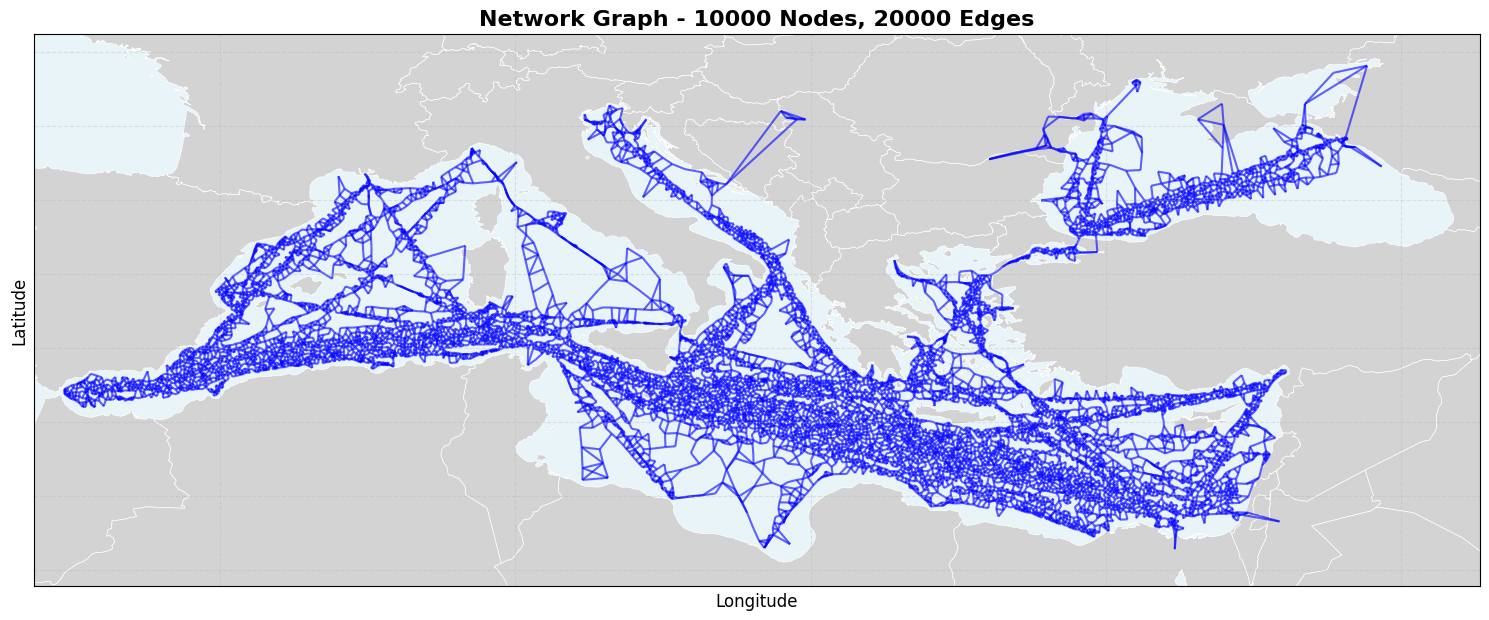


Network visualization complete!
Nodes: 10000
Edges: 20000
Average degree: 4.00


In [13]:
# Load higher resolution world map
world = gpd.read_file('https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip')

# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 12))

# Plot the world map as background
world.plot(ax=ax, color='lightgray', edgecolor='white', linewidth=0.5)

# Set map extent based on data bounds (with padding)
lon_min, lon_max = ORIGINAL_LON_MIN - 1, ORIGINAL_LON_MAX + 1
lat_min, lat_max = ORIGINAL_LAT_MIN - 1, ORIGINAL_LAT_MAX + 1
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

# Get node positions for NetworkX
pos = nx.get_node_attributes(G, 'pos')

# Draw network edges only (no nodes)
nx.draw_networkx_edges(G, pos, ax=ax, 
                       edge_color='blue', 
                       width=1.5, 
                       alpha=0.6)

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.3)

# Labels and title
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title(f'Network Graph - {G.number_of_nodes()} Nodes, {G.number_of_edges()} Edges', 
             fontsize=16, fontweight='bold')

# Set background color
ax.set_facecolor('#E8F4F8')

plt.tight_layout()
plt.show()

print(f"\nNetwork visualization complete!")
print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")
print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")

In [14]:
# Load all port CSV files from port_data folder
port_data_folder = "../../data/port_data"
port_csv_files = glob.glob(f"{port_data_folder}/*.csv")

print(f"Found {len(port_csv_files)} port CSV files in {port_data_folder}:")
for file in sorted(port_csv_files):
    print(f"  - {Path(file).name}")

# Load and concatenate all port CSV files
all_port_data = []
for csv_file in tqdm(port_csv_files, desc="Loading port CSV files"):
    try:
        # Read with encoding to handle special characters
        df = pd.read_csv(csv_file, encoding='utf-8-sig')
        all_port_data.append(df)
    except Exception as e:
        print(f"Error loading {csv_file}: {e}")

# Concatenate all port dataframes
ports_combined = pd.concat(all_port_data, ignore_index=True)

# replace with COMTRADE country names where appropriate
for key, value in COUNTRY_NAME_CONVERTER.items():
    ports_combined.loc[ports_combined['countryName'] == key, 'countryName'] = value

print(f"\nTotal ports loaded: {len(ports_combined)}")
print(f"Columns: {ports_combined.columns.tolist()[:10]}...")  # Show first 10 columns
ports_combined.head()

Found 25 port CSV files in ../../data/port_data:
  - albania_ports.csv
  - algeria_ports.csv
  - bosnia_ports.csv
  - bulgaria_ports.csv
  - crotatia_ports.csv
  - cyprus_ports.csv
  - egypt_ports.csv
  - france_ports.csv
  - georgia_ports.csv
  - greece_ports.csv
  - israel_ports.csv
  - italy_ports.csv
  - lebanon_ports.csv
  - lybia_ports.csv
  - malta_ports.csv
  - montenegro_ports.csv
  - morocco_ports.csv
  - romania_ports.csv
  - russia_ports.csv
  - slovenia_ports.csv
  - spain_ports.csv
  - syria_ports.csv
  - tunisia_ports.csv
  - turkey_ports.csv
  - ukraine_ports.csv


Loading port CSV files: 100%|██████████| 25/25 [00:00<00:00, 370.01it/s]


Total ports loaded: 522
Columns: ['portNumber', 'portName', 'regionNumber', 'regionName', 'countryCode', 'countryName', 'latitude', 'longitude', 'publicationNumber', 'chartNumber']...



/var/folders/3d/fbytqdpn2m599fcr4p1zr9_h0000gn/T/ipykernel_76066/2699085662.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ports_combined = pd.concat(all_port_data, ignore_index=True)


portNumber        portName regionNumber regionName countryCode countryName  \
0      45802          Agadir        45700    MOROCCO          MA     Morocco   
1      45793      Casablanca        45700    MOROCCO          MA     Morocco   
2      45795       El Jadida        45700    MOROCCO          MA     Morocco   
3      45796  El Jorf Lasfar        45700    MOROCCO          MA     Morocco   
4      45800       Essaouira        45700    MOROCCO          MA     Morocco   

     latitude  longitude                                  publicationNumber  \
0  30°26'00"N  9°38'00"W  Sailing Directions Pub. 143 (Enroute) - West C...   
1  33°36'00"N  7°37'00"W  Sailing Directions Pub. 143 (Enroute) - West C...   
2  33°15'00"N  8°30'00"W  Sailing Directions Pub. 143 (Enroute) - West C...   
3  33°07'00"N  8°37'00"W  Sailing Directions Pub. 143 (Enroute) - West C...   
4  31°30'00"N  9°47'00"W  Sailing Directions Pub. 143 (Enroute) - West C...   

  chartNumber  ... s57Enc s101Enc          dodWaterBody   alternateName  \
0       51225  ...    NaN     NaN  North Atlantic Ocean             NaN   
1       51222  ...    NaN     NaN  North Atlantic Ocean    Dar El Beida   
2       51240  ...    NaN     NaN  North Atlantic Ocean         Mazagan   
3       51240  ...    NaN     NaN  North Atlantic Ocean             NaN   
4       51280  ...    NaN     NaN  North Atlantic Ocean  Mogador; Suira   

  entranceWidth lngTerminalDepth offMaxVesselLength offMaxVesselBeam  \
0           NaN              NaN                NaN              NaN   
1           NaN              NaN                NaN              NaN   
2           NaN              NaN                NaN              NaN   
3           NaN              NaN                NaN              NaN   
4           NaN              NaN                NaN              NaN   

  offMaxVesselDraft  Unnamed: 110  
0               NaN           NaN  
1               NaN           NaN  
2               NaN           NaN  
3               NaN           NaN  
4               NaN           NaN  

[5 rows x 111 columns]

In [15]:
# Parse latitude and longitude from string format to decimal degrees
def parse_coordinate(coord_str):
    """
    Convert coordinate string like '41°19'00"N' to decimal degrees
    """
    if pd.isna(coord_str):
        return None
    
    try:
        # Remove quotes and split
        coord_str = str(coord_str).strip()
        
        # Extract direction (N/S/E/W)
        direction = coord_str[-1]
        
        # Extract degrees, minutes, seconds
        # Format: DD°MM'SS"D where D is direction
        parts = coord_str[:-1].replace('"', '').replace("'", '°').split('°')
        
        degrees = float(parts[0])
        minutes = float(parts[1]) if len(parts) > 1 and parts[1] else 0
        seconds = float(parts[2]) if len(parts) > 2 and parts[2] else 0
        
        # Convert to decimal
        decimal = degrees + minutes/60 + seconds/3600
        
        # Apply direction
        if direction in ['S', 'W']:
            decimal = -decimal
            
        return decimal
    except:
        return None

# Parse coordinates
print("Parsing port coordinates...")
ports_combined['lon'] = ports_combined['longitude'].apply(parse_coordinate)
ports_combined['lat'] = ports_combined['latitude'].apply(parse_coordinate)

# Remove ports with invalid coordinates
ports_combined = ports_combined.dropna(subset=['lon', 'lat'])
print(f"Ports with valid coordinates: {len(ports_combined)}")

ports_combined[['portName', 'latitude', 'longitude', 'lat', 'lon']].head()

Parsing port coordinates...
Ports with valid coordinates: 522


portName    latitude  longitude        lat       lon
0          Agadir  30°26'00"N  9°38'00"W  30.433333 -9.633333
1      Casablanca  33°36'00"N  7°37'00"W  33.600000 -7.616667
2       El Jadida  33°15'00"N  8°30'00"W  33.250000 -8.500000
3  El Jorf Lasfar  33°07'00"N  8°37'00"W  33.116667 -8.616667
4       Essaouira  31°30'00"N  9°47'00"W  31.500000 -9.783333

In [16]:
# Filter ports by water body and harbor size
print(f"Filtering ports by water bodies: {WATER_BODIES}")
print(f"Filtering ports by harbor sizes: {HARBOR_SIZES}")
print(f"Additional ports by name: {ADDITIONAL_PORTS_BY_NAME}")

# Filter by water body - check if any of the specified water bodies appear in dodWaterBody
water_body_mask = ports_combined['dodWaterBody'].apply(
    lambda x: any(wb in str(x) for wb in WATER_BODIES) if pd.notna(x) else False
)

# Filter by harbor size
harbor_size_mask = ports_combined['harborSize'].isin(HARBOR_SIZES)

# Filter by manual port name list
name_mask = ports_combined['portName'].isin(ADDITIONAL_PORTS_BY_NAME)

# Apply filters: (water body AND harbor size) OR manual name
filtered_ports = ports_combined[(water_body_mask & harbor_size_mask) | name_mask].copy()

print(f"\nFiltering results:")
print(f"  Total ports: {len(ports_combined)}")
print(f"  Ports in specified water bodies: {water_body_mask.sum()}")
print(f"  Ports with specified harbor sizes: {harbor_size_mask.sum()}")
print(f"  Ports matching both criteria: {(water_body_mask & harbor_size_mask).sum()}")
print(f"  Manually added ports by name: {name_mask.sum()}")
print(f"  Total ports after filtering: {len(filtered_ports)}")

# Show distribution by harbor size
print(f"\nHarbor size distribution:")
print(filtered_ports['harborSize'].value_counts().sort_index())

# Show distribution by country
print(f"\nTop 10 countries by port count:")
print(filtered_ports['countryName'].value_counts().head(10))

# Show manually added ports
if name_mask.sum() > 0:
    print(f"\nManually added ports:")
    for port_name in ADDITIONAL_PORTS_BY_NAME:
        port_info = filtered_ports[filtered_ports['portName'] == port_name]
        if len(port_info) > 0:
            port = port_info.iloc[0]
            print(f"  - {port['portName']} ({port['countryName']}): Size {port['harborSize']}")
        else:
            print(f"  - {port_name}: NOT FOUND in dataset")

filtered_ports[['portName', 'countryName', 'harborSize', 'lat', 'lon', 'dodWaterBody']].head(10)

Filtering ports by water bodies: ['Mediterranean Sea', 'Black Sea', 'Strait of Gibraltar']
Filtering ports by harbor sizes: ['V', 'S', 'M', 'L']
Additional ports by name: ['Tunis', 'Mina Tarabulus (Tripoli)', 'Haifa', 'Bar', 'Sayda', 'Larnaca', 'Constanta', 'Durres', 'Neum', 'Koper', 'Valletta Harbors']

Filtering results:
  Total ports: 522
  Ports in specified water bodies: 389
  Ports with specified harbor sizes: 522
  Ports matching both criteria: 389
  Manually added ports by name: 11
  Total ports after filtering: 389

Harbor size distribution:
harborSize
L     31
M     36
S    101
V    221
Name: count, dtype: int64

Top 10 countries by port count:
countryName
Italy      79
Greece     64
Türkiye    54
Spain      28
Ukraine    26
France     21
Algeria    17
Croatia    16
Tunisia    16
Libya      14
Name: count, dtype: int64

Manually added ports:
  - Tunis (Tunisia): Size M
  - Mina Tarabulus (Tripoli) (Libya): Size M
  - Haifa (Israel): Size M
  - Bar (Montenegro): Size S
  - Say

portName countryName harborSize        lat        lon  \
7       Port D Al Hoceima     Morocco          V  35.250000  -3.916667   
8              Port Nador     Morocco          V  35.283333  -2.933333   
10                 Tanger     Morocco          M  35.783333  -5.816667   
11  Tangier-Mediterranean     Morocco          L  35.900000  -5.516667   
12               Dhekelia      Cyprus          V  34.966667  33.716667   
13              Famagusta      Cyprus          S  35.116667  33.933333   
14                Kyrenia      Cyprus          V  35.350000  33.333333   
15                Larnaca      Cyprus          S  34.916667  33.650000   
16               Limassol      Cyprus          S  34.666667  33.050000   
17                  Xeros      Cyprus          V  35.133333  32.833333   

                                 dodWaterBody  
7     Mediterranean Sea; North Atlantic Ocean  
8     Mediterranean Sea; North Atlantic Ocean  
10  Strait of Gibraltar; North Atlantic Ocean  
11  Strait of Gibraltar; North Atlantic Ocean  
12    Mediterranean Sea; North Atlantic Ocean  
13    Mediterranean Sea; North Atlantic Ocean  
14    Mediterranean Sea; North Atlantic Ocean  
15    Mediterranean Sea; North Atlantic Ocean  
16    Mediterranean Sea; North Atlantic Ocean  
17    Mediterranean Sea; North Atlantic Ocean

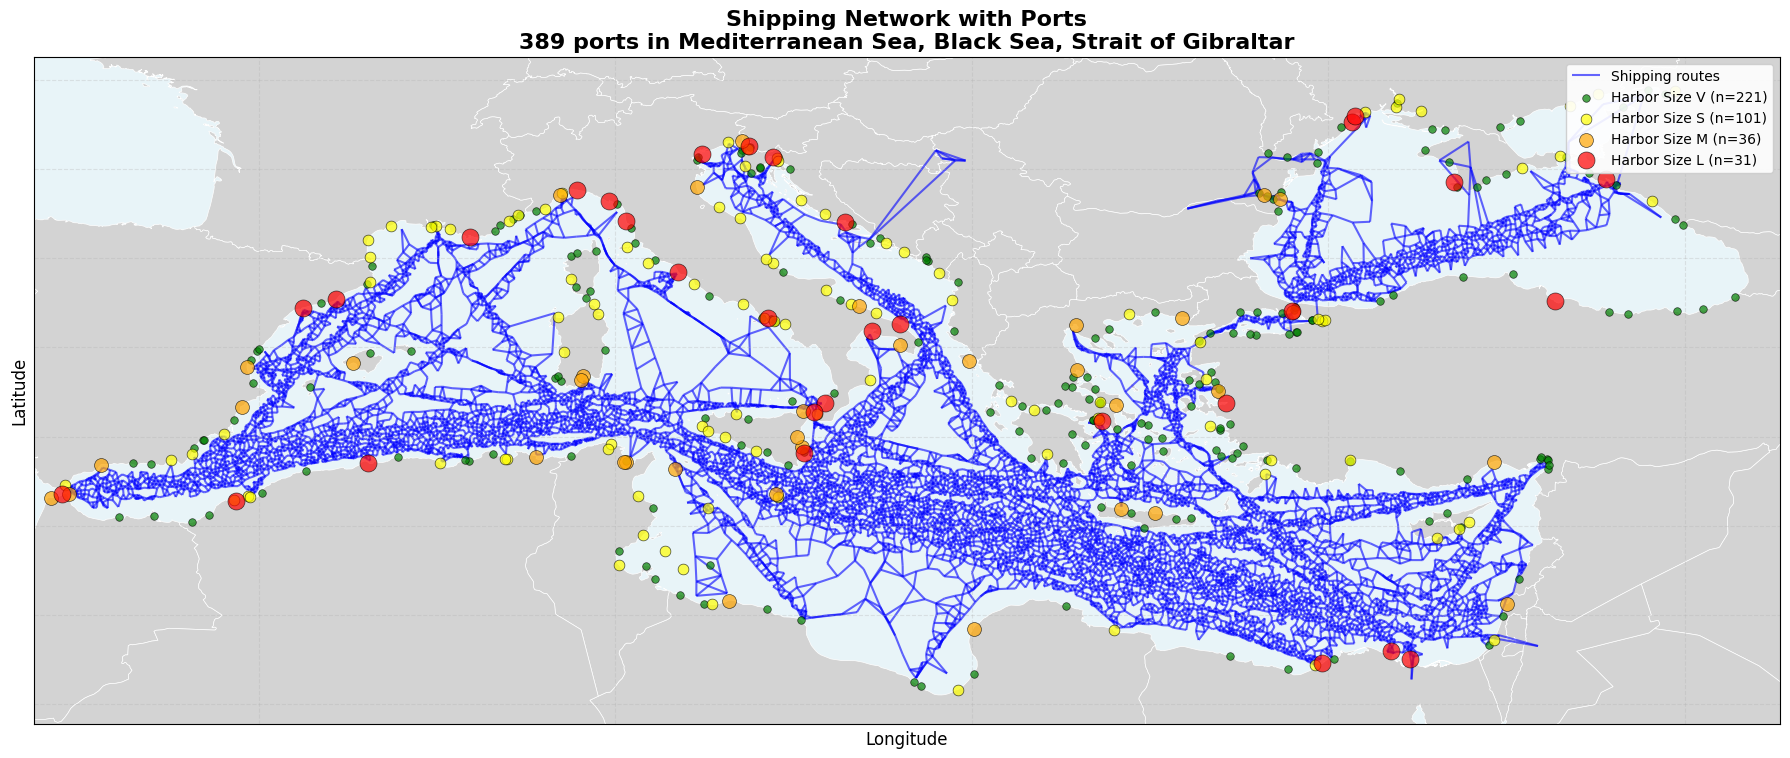


Visualization complete!
Network: 10000 nodes, 20000 edges
Ports displayed: 389
Harbor size breakdown: {'L': np.int64(31), 'M': np.int64(36), 'S': np.int64(101), 'V': np.int64(221)}


In [17]:
# Visualize ports on top of the network graph with map
fig, ax = plt.subplots(figsize=(18, 14))

# Plot the world map as background
world.plot(ax=ax, color='lightgray', edgecolor='white', linewidth=0.5)

# Set map extent based on data bounds (with padding)
lon_min, lon_max = ORIGINAL_LON_MIN - 1, ORIGINAL_LON_MAX + 1
lat_min, lat_max = ORIGINAL_LAT_MIN - 1, ORIGINAL_LAT_MAX + 1
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

# Get node positions for NetworkX
pos = nx.get_node_attributes(G, 'pos')

# Draw network edges (shipping routes) in blue
nx.draw_networkx_edges(G, pos, ax=ax, 
                       edge_color='blue', 
                       width=1.5, 
                       alpha=0.6,
                       label='Shipping routes')

# Create color and size mappings for ports by harbor size
harbor_colors = {
    'V': 'green',      # Very Small
    'S': 'yellow',     # Small
    'M': 'orange',     # Medium
    'L': 'red'         # Large
}

harbor_sizes_plot = {
    'V': 30,   # Very Small
    'S': 60,   # Small
    'M': 100,  # Medium
    'L': 150   # Large
}

# Plot ports by harbor size
for size in HARBOR_SIZES:
    ports_subset = filtered_ports[filtered_ports['harborSize'] == size]
    if len(ports_subset) > 0:
        ax.scatter(ports_subset['lon'], 
                  ports_subset['lat'],
                  c=harbor_colors[size],
                  s=harbor_sizes_plot[size],
                  alpha=0.7,
                  edgecolors='black',
                  linewidths=0.5,
                  label=f'Harbor Size {size} (n={len(ports_subset)})',
                  zorder=5)

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.3)

# Labels and title
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title(f'Shipping Network with Ports\n{len(filtered_ports)} ports in {", ".join(WATER_BODIES)}', 
             fontsize=16, fontweight='bold')

# Set background color
ax.set_facecolor('#E8F4F8')

# Add legend
ax.legend(loc='upper right', fontsize=10, framealpha=0.9)

plt.tight_layout()
plt.show()

print(f"\nVisualization complete!")
print(f"Network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"Ports displayed: {len(filtered_ports)}")
print(f"Harbor size breakdown: {dict(filtered_ports['harborSize'].value_counts().sort_index())}")

In [18]:
# Filter for L-sized harbors + manually added ports
large_ports = filtered_ports[
    (filtered_ports['harborSize'] == 'L') | 
    (filtered_ports['portName'].isin(ADDITIONAL_PORTS_BY_NAME))
].copy()
large_ports.reset_index(drop=True, inplace=True)

print(f"Large (L) ports in {', '.join(WATER_BODIES)}: {(filtered_ports['harborSize'] == 'L').sum()}")
print(f"Manually added ports: {filtered_ports['portName'].isin(ADDITIONAL_PORTS_BY_NAME).sum()}")
print(f"Total ports to include in network: {len(large_ports)}")

print(f"\nLarge ports by country:")
print(large_ports['countryName'].value_counts())

# Show breakdown by harbor size
print(f"\nPorts by harbor size:")
print(large_ports['harborSize'].value_counts().sort_index())

large_ports[['portName', 'countryName', 'harborSize', 'lat', 'lon', 'dodWaterBody']].head(10)

Large (L) ports in Mediterranean Sea, Black Sea, Strait of Gibraltar: 31
Manually added ports: 11
Total ports to include in network: 42

Large ports by country:
countryName
Italy                     12
Türkiye                    3
Ukraine                    3
Egypt                      3
Spain                      2
Algeria                    2
Croatia                    2
Morocco                    1
Albania                    1
Tunisia                    1
France                     1
Libya                      1
Bosnia And Herzegovina     1
Montenegro                 1
Russian Federation         1
Cyprus                     1
Israel                     1
Lebanon                    1
Slovenia                   1
Malta                      1
Romania                    1
Greece                     1
Name: count, dtype: int64

Ports by harbor size:
harborSize
L    31
M     5
S     5
V     1
Name: count, dtype: int64


portName countryName harborSize        lat        lon  \
0  Tangier-Mediterranean     Morocco          L  35.900000  -5.516667   
1                Larnaca      Cyprus          S  34.916667  33.650000   
2              Constanta     Romania          M  44.166667  28.650000   
3               Brindisi       Italy          L  40.650000  17.983333   
4          Civitavecchia       Italy          L  42.102000  11.771000   
5                 Genova       Italy          L  44.398000   8.922000   
6            Gioia Tauro       Italy          L  38.444000  15.890000   
7              La Spezia       Italy          L  44.100000   9.833333   
8                Livorno       Italy          L  43.542000  10.290000   
9                Messina       Italy          L  38.200000  15.566667   

                                        dodWaterBody  
0          Strait of Gibraltar; North Atlantic Ocean  
1            Mediterranean Sea; North Atlantic Ocean  
2                    Black Sea; North Atlantic Ocean  
3  Adriatic Sea; Mediterranean Sea; North Atlanti...  
4  Tyrrhenian Sea; Mediterranean Sea; North Atlan...  
5  Ligurian Sea; Mediterranean Sea; North Atlanti...  
6  Tyrrhenian Sea; Mediterranean Sea; North Atlan...  
7  Ligurian Sea; Mediterranean Sea; North Atlanti...  
8  Ligurian Sea; Mediterranean Sea; North Atlanti...  
9            Mediterranean Sea; North Atlantic Ocean

In [19]:
# Create a new graph G_with_ports that includes the network and large ports
G_with_ports = G.copy()

# Starting node index for ports (use string identifiers to avoid conflicts)
port_node_ids = []

# Get coordinates of existing network nodes
network_coords = aggregated_data[['lon', 'lat']].values

print(f"Adding {len(large_ports)} large ports to the graph...")

# Add each large port as a node and connect to 10 nearest network nodes
for idx, port in tqdm(large_ports.iterrows(), total=len(large_ports), desc="Adding port nodes"):
    # Create unique port node ID
    port_id = f"port_{idx}"
    port_node_ids.append(port_id)
    
    # Add port as a node
    G_with_ports.add_node(port_id,
                         pos=(port['lon'], port['lat']),
                         lon=port['lon'],
                         lat=port['lat'],
                         source='port',
                         portName=port['portName'],
                         country=port['countryName'])
    
    # Calculate distances from this port to all network nodes
    port_coords = np.array([[port['lon'], port['lat']]])
    distances_to_network = distance_matrix(port_coords, network_coords)[0]
    
    # Find indices of 10 closest network nodes
    closest_indices = np.argsort(distances_to_network)[:10]
    
    # Connect port to its 10 nearest network nodes
    for closest_idx in closest_indices:
        network_node_id = aggregated_data.index[closest_idx]
        distance = distances_to_network[closest_idx]
        
        G_with_ports.add_edge(port_id, network_node_id, 
                             distance=distance, 
                             source='port_connection')

print(f"\nGraph with ports created:")
print(f"  Total nodes: {G_with_ports.number_of_nodes()} ({len(port_node_ids)} ports + {G.number_of_nodes()} network nodes)")
print(f"  Total edges: {G_with_ports.number_of_edges()}")
print(f"  New edges added: {G_with_ports.number_of_edges() - G.number_of_edges()}")

# Store port node IDs for later use
large_ports['node_id'] = port_node_ids

Adding 42 large ports to the graph...


Adding port nodes: 100%|██████████| 42/42 [00:00<00:00, 1505.85it/s]


Graph with ports created:
  Total nodes: 10042 (42 ports + 10000 network nodes)
  Total edges: 20420
  New edges added: 420


In [20]:
# Add choke points to the network
print(f"Adding {len(CHOKE_POINTS)} choke points to the graph...")

# Get coordinates of existing network nodes
network_coords = aggregated_data[['lon', 'lat']].values

choke_point_node_ids = []
for idx, choke_point in enumerate(tqdm(CHOKE_POINTS, desc="Adding choke point nodes")):
    # Create unique choke point node ID
    choke_id = f"choke_{idx}"
    choke_point_node_ids.append(choke_id)
    
    # Add choke point as a node
    G_with_ports.add_node(choke_id,
                         pos=(choke_point['lon'], choke_point['lat']),
                         lon=choke_point['lon'],
                         lat=choke_point['lat'],
                         source='choke_point',
                         name=choke_point['name'])
    
    # Calculate distances from this choke point to all network nodes
    choke_coords = np.array([[choke_point['lon'], choke_point['lat']]])
    distances_to_network = distance_matrix(choke_coords, network_coords)[0]
    
    # Find indices of 10 closest network nodes
    closest_indices = np.argsort(distances_to_network)[:10]
    
    # Connect choke point to its 10 nearest network nodes
    for closest_idx in closest_indices:
        network_node_id = aggregated_data.index[closest_idx]
        distance = distances_to_network[closest_idx]
        
        G_with_ports.add_edge(choke_id, network_node_id, 
                             distance=distance, 
                             source='choke_point_connection')

print(f"\nChoke points added to graph:")
print(f"  Total nodes: {G_with_ports.number_of_nodes()}")
print(f"  Total edges: {G_with_ports.number_of_edges()}")
print(f"  Choke points added: {len(choke_point_node_ids)}")

# Show choke point details
print(f"\nChoke point details:")
for choke_id in choke_point_node_ids:
    choke_attrs = G_with_ports.nodes[choke_id]
    print(f"  - {choke_attrs['name']}: ({choke_attrs['lon']:.4f}, {choke_attrs['lat']:.4f})")

Adding 1 choke points to the graph...


Adding choke point nodes: 100%|██████████| 1/1 [00:00<00:00, 747.38it/s]


Choke points added to graph:
  Total nodes: 10043
  Total edges: 20430
  Choke points added: 1

Choke point details:
  - Dardanelles: (26.6709, 40.3860)


In [21]:
# Define heuristic function for A* (Euclidean distance)
def heuristic(node1, node2, graph):
    """
    Calculate Euclidean distance between two nodes for A* heuristic
    """
    lon1 = graph.nodes[node1]['lon']
    lat1 = graph.nodes[node1]['lat']
    lon2 = graph.nodes[node2]['lon']
    lat2 = graph.nodes[node2]['lat']
    
    return np.sqrt((lon2 - lon1)**2 + (lat2 - lat1)**2)

# Collect all nodes and edges used in any shortest path
used_nodes = set()
used_edges = set()

# Get list of port node IDs and choke point node IDs
port_ids = large_ports['node_id'].tolist()
choke_ids = choke_point_node_ids if 'choke_point_node_ids' in dir() else []

# Combine ports and choke points for pathfinding
all_special_nodes = port_ids + choke_ids
n_nodes = len(all_special_nodes)

print(f"Running A* algorithm between all pairs of special nodes...")
print(f"  Ports: {len(port_ids)}")
print(f"  Choke points: {len(choke_ids)}")
print(f"  Total special nodes: {n_nodes}")
print(f"  Total paths to compute: {n_nodes * (n_nodes - 1) // 2}")

# Track paths found and failed
paths_found = 0
paths_failed = 0

# Run A* between all pairs of special nodes (ports and choke points)
for i in tqdm(range(n_nodes), desc="Computing shortest paths"):
    source_node = all_special_nodes[i]
    
    for j in range(i + 1, n_nodes):
        target_node = all_special_nodes[j]
        
        try:
            # Run A* algorithm with distance as weight and Euclidean distance as heuristic
            path = nx.astar_path(G_with_ports, 
                                source_node, 
                                target_node,
                                heuristic=lambda n1, n2: heuristic(n1, n2, G_with_ports),
                                weight='distance')
            
            # Add all nodes in the path to used_nodes
            used_nodes.update(path)
            
            # Add all edges in the path to used_edges
            for k in range(len(path) - 1):
                # Create edge tuple - NetworkX handles undirected edges, so order doesn't matter
                # We'll use frozenset to make edges order-independent
                edge = frozenset([path[k], path[k+1]])
                used_edges.add(edge)
            
            paths_found += 1
            
        except nx.NetworkXNoPath:
            # No path exists between these two nodes
            paths_failed += 1
            continue

print(f"\nA* search complete:")
print(f"  Paths found: {paths_found}")
print(f"  Paths failed (no connection): {paths_failed}")
print(f"  Unique nodes used: {len(used_nodes)}")
print(f"  Unique edges used: {len(used_edges)}")
print(f"  Percentage of original network used: {len(used_nodes) / G_with_ports.number_of_nodes() * 100:.1f}% nodes, {len(used_edges) / G_with_ports.number_of_edges() * 100:.1f}% edges")

Running A* algorithm between all pairs of special nodes...
  Ports: 42
  Choke points: 1
  Total special nodes: 43
  Total paths to compute: 903


Computing shortest paths: 100%|██████████| 43/43 [00:05<00:00,  8.31it/s]


A* search complete:
  Paths found: 903
  Paths failed (no connection): 0
  Unique nodes used: 3038
  Unique edges used: 3236
  Percentage of original network used: 30.2% nodes, 15.8% edges


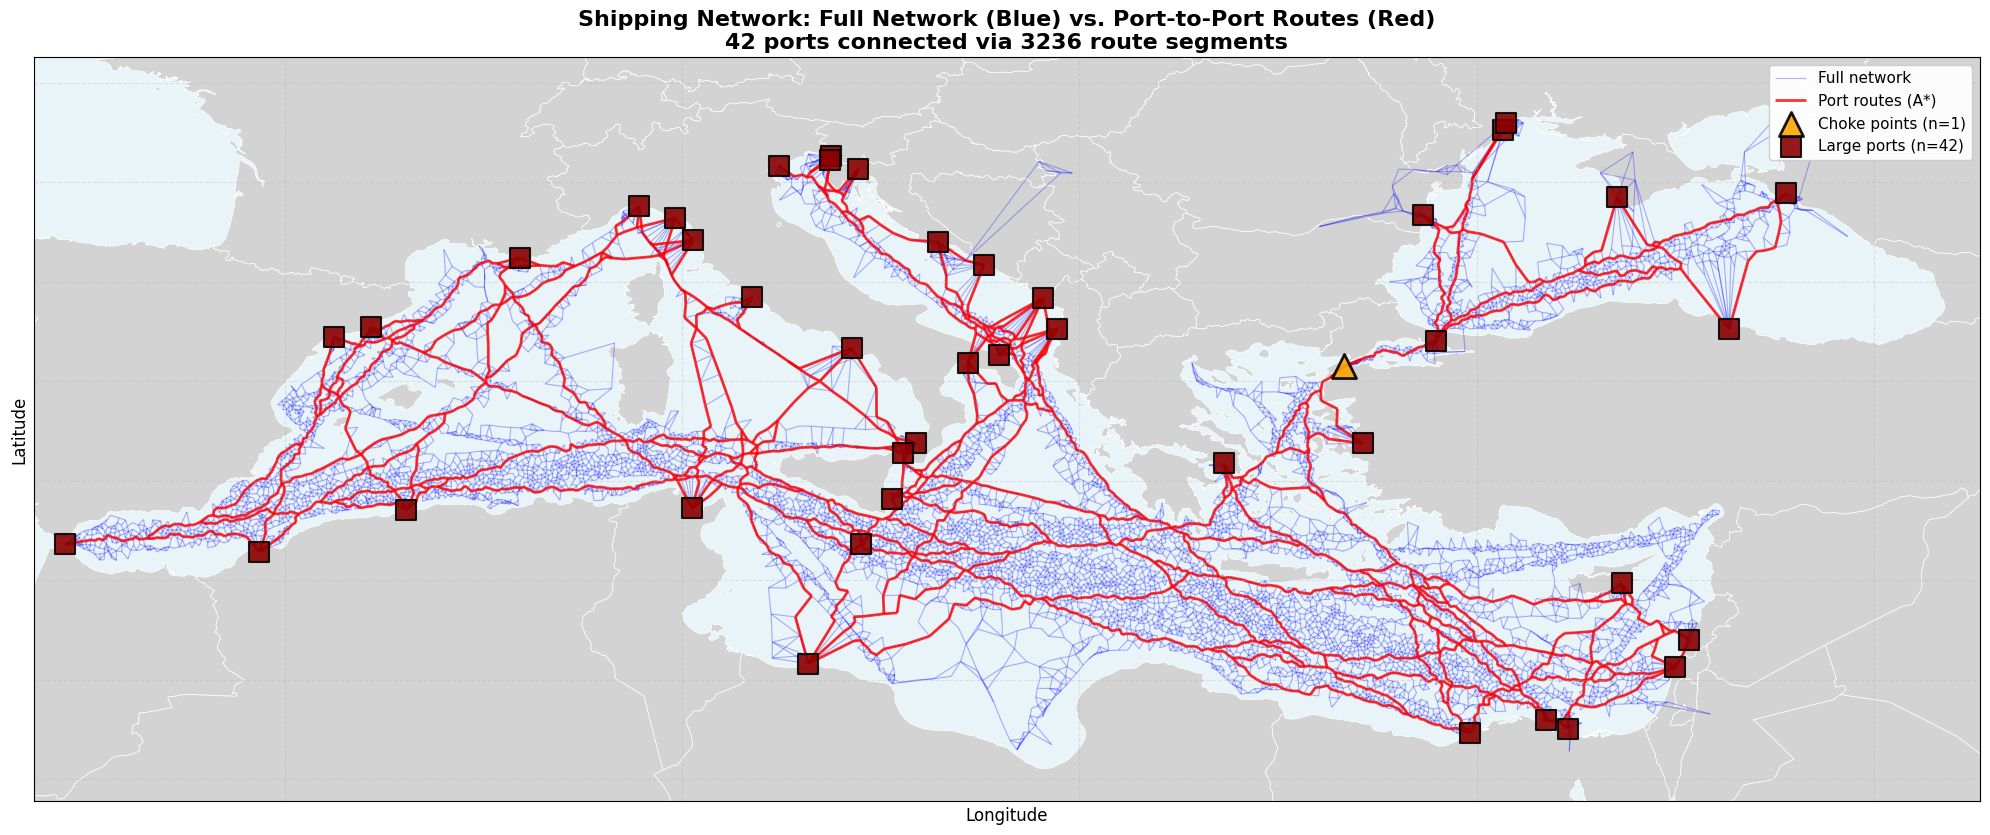


Visualization complete!
Full network: 10043 nodes, 20430 edges
Filtered network (red): 3038 nodes, 3236 edges
Reduction: 69.8% fewer nodes, 84.2% fewer edges


In [22]:
# Visualize original network (blue) with filtered network (red) on top
fig, ax = plt.subplots(figsize=(20, 16))

# Plot the world map as background
world.plot(ax=ax, color='lightgray', edgecolor='white', linewidth=0.5)

# Set map extent based on data bounds (with padding)
lon_min, lon_max = ORIGINAL_LON_MIN - 1, ORIGINAL_LON_MAX + 1
lat_min, lat_max = ORIGINAL_LAT_MIN - 1, ORIGINAL_LAT_MAX + 1
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

# Get node positions for NetworkX
pos = nx.get_node_attributes(G_with_ports, 'pos')

# Draw ALL network edges in blue (original network)
nx.draw_networkx_edges(G_with_ports, pos, ax=ax, 
                       edge_color='blue', 
                       width=0.8, 
                       alpha=0.3,
                       label='Full network')

# Convert frozenset edges to tuples for NetworkX
used_edges_list = [tuple(edge) for edge in used_edges]

# Draw ONLY the edges used in shortest paths in red
nx.draw_networkx_edges(G_with_ports, pos, ax=ax,
                       edgelist=used_edges_list,
                       edge_color='red',
                       width=2.0,
                       alpha=0.8,
                       label=f'Port routes (A*)')


# Plot choke points
if 'choke_point_node_ids' in dir() and len(choke_point_node_ids) > 0:
    choke_lons = [G_with_ports.nodes[cp]['lon'] for cp in choke_point_node_ids]
    choke_lats = [G_with_ports.nodes[cp]['lat'] for cp in choke_point_node_ids]
    ax.scatter(choke_lons, choke_lats,
              c='orange', s=300, alpha=0.9,
              edgecolors='black', linewidths=2,
              label=f'Choke points (n={len(choke_point_node_ids)})',
              zorder=11, marker='^')  # Triangle markers for choke points

# Plot large ports
ax.scatter(large_ports['lon'], 
          large_ports['lat'],
          c='darkred',
          s=200,
          alpha=0.9,
          edgecolors='black',
          linewidths=1.5,
          label=f'Large ports (n={len(large_ports)})',
          zorder=10,
          marker='s')  # Square markers for ports

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.3)

# Labels and title
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title(f'Shipping Network: Full Network (Blue) vs. Port-to-Port Routes (Red)\n' + 
             f'{len(large_ports)} ports connected via {len(used_edges)} route segments',
             fontsize=16, fontweight='bold')

# Set background color
ax.set_facecolor('#E8F4F8')

# Add legend
ax.legend(loc='upper right', fontsize=11, framealpha=0.95)

plt.tight_layout()
plt.show()

print(f"\nVisualization complete!")
print(f"Full network: {G_with_ports.number_of_nodes()} nodes, {G_with_ports.number_of_edges()} edges")
print(f"Filtered network (red): {len(used_nodes)} nodes, {len(used_edges)} edges")
print(f"Reduction: {(1 - len(used_nodes)/G_with_ports.number_of_nodes())*100:.1f}% fewer nodes, {(1 - len(used_edges)/G_with_ports.number_of_edges())*100:.1f}% fewer edges")

In [23]:
# Create new graph containing only nodes and edges used in port-to-port routes
G_filtered = nx.Graph()

print(f"Creating filtered graph with only used nodes and edges...")

# Add all used nodes with their attributes
for node in tqdm(used_nodes, desc="Adding nodes"):
    # Copy node attributes from original graph
    node_attrs = G_with_ports.nodes[node]
    G_filtered.add_node(node, **node_attrs)

# Add all used edges with their attributes
for edge in tqdm(used_edges, desc="Adding edges"):
    # Convert frozenset to tuple
    node1, node2 = tuple(edge)
    # Copy edge attributes from original graph
    edge_attrs = G_with_ports.edges[node1, node2]
    G_filtered.add_edge(node1, node2, **edge_attrs)

print(f"\nFiltered graph created:")
print(f"  Nodes: {G_filtered.number_of_nodes()}")
print(f"  Edges: {G_filtered.number_of_edges()}")
print(f"  Is connected: {nx.is_connected(G_filtered)}")
print(f"  Number of connected components: {nx.number_connected_components(G_filtered)}")

# Count port nodes vs network nodes
port_nodes = [n for n in G_filtered.nodes() if G_filtered.nodes[n].get('source') == 'port']
network_nodes = [n for n in G_filtered.nodes() if G_filtered.nodes[n].get('source') == 'density']

print(f"\nNode breakdown:")
print(f"  Port nodes: {len(port_nodes)}")
print(f"  Network nodes: {len(network_nodes)}")

# Calculate average degree
avg_degree = sum(dict(G_filtered.degree()).values()) / G_filtered.number_of_nodes()
print(f"  Average degree: {avg_degree:.2f}")

# Show some basic statistics
print(f"\nComparison to original graph:")
print(f"  Original: {G_with_ports.number_of_nodes()} nodes, {G_with_ports.number_of_edges()} edges")
print(f"  Filtered: {G_filtered.number_of_nodes()} nodes, {G_filtered.number_of_edges()} edges")
print(f"  Retained: {G_filtered.number_of_nodes()/G_with_ports.number_of_nodes()*100:.1f}% of nodes, {G_filtered.number_of_edges()/G_with_ports.number_of_edges()*100:.1f}% of edges")

Creating filtered graph with only used nodes and edges...


Adding edges: 100%|██████████| 3236/3236 [00:00<00:00, 292063.34it/s]


Filtered graph created:
  Nodes: 3038
  Edges: 3236
  Is connected: True
  Number of connected components: 1

Node breakdown:
  Port nodes: 42
  Network nodes: 2995
  Average degree: 2.13

Comparison to original graph:
  Original: 10043 nodes, 20430 edges
  Filtered: 3038 nodes, 3236 edges
  Retained: 30.2% of nodes, 15.8% of edges


In [24]:
# DIAGNOSTIC: Check if choke points are in G_filtered
print("="*80)
print("DIAGNOSTIC: Checking for choke points in G_filtered")
print("="*80)

choke_in_filtered = [n for n in G_filtered.nodes() if G_filtered.nodes[n].get('source') == 'choke_point']
print(f"Choke points in G_filtered: {len(choke_in_filtered)}")

if choke_in_filtered:
    for cp in choke_in_filtered:
        attrs = G_filtered.nodes[cp]
        print(f"  ✓ {cp}: {attrs.get('name', 'unnamed')} at ({attrs.get('lon')}, {attrs.get('lat')})")
        print(f"    Degree: {G_filtered.degree(cp)}")
else:
    print("  ❌ NO CHOKE POINTS FOUND IN G_filtered!")
    print("  This means choke points were not included in A* paths.")
    
print("Node type breakdown in G_filtered:")
sources = {}
for n in G_filtered.nodes():
    source = G_filtered.nodes[n].get('source', 'unknown')
    sources[source] = sources.get(source, 0) + 1
for source, count in sorted(sources.items()):
    print(f"  {source}: {count}")


DIAGNOSTIC: Checking for choke points in G_filtered
Choke points in G_filtered: 1
  ✓ choke_0: Dardanelles at (26.670913795551606, 40.385990414396176)
    Degree: 2
Node type breakdown in G_filtered:
  choke_point: 1
  density: 2995
  port: 42


### Summary: Port-to-Port Routing Analysis

This analysis:
1. **Filtered** for Large (L) harbor size ports in Mediterranean Sea and Black Sea
2. **Added** each large port as a node in the network
3. **Connected** each port to its 10 nearest network nodes
4. **Ran A* algorithm** between all pairs of large ports to find optimal routes
5. **Collected** all nodes and edges that appear in any shortest path
6. **Created** a filtered graph (`G_filtered`) containing only the essential routing infrastructure

**Key Results:**
- The filtered network represents the critical shipping routes connecting major ports
- This reduced graph maintains connectivity while removing unused portions of the network
- All port-to-port routes use only the edges shown in red in the visualization above

ALGORITHM 1: Contraction Hierarchies Simplification
Starting graph: 3038 nodes, 3236 edges
Contracted 2710 degree-2 nodes
Final graph: 328 nodes, 526 edges
Reduction: 89.2% fewer nodes


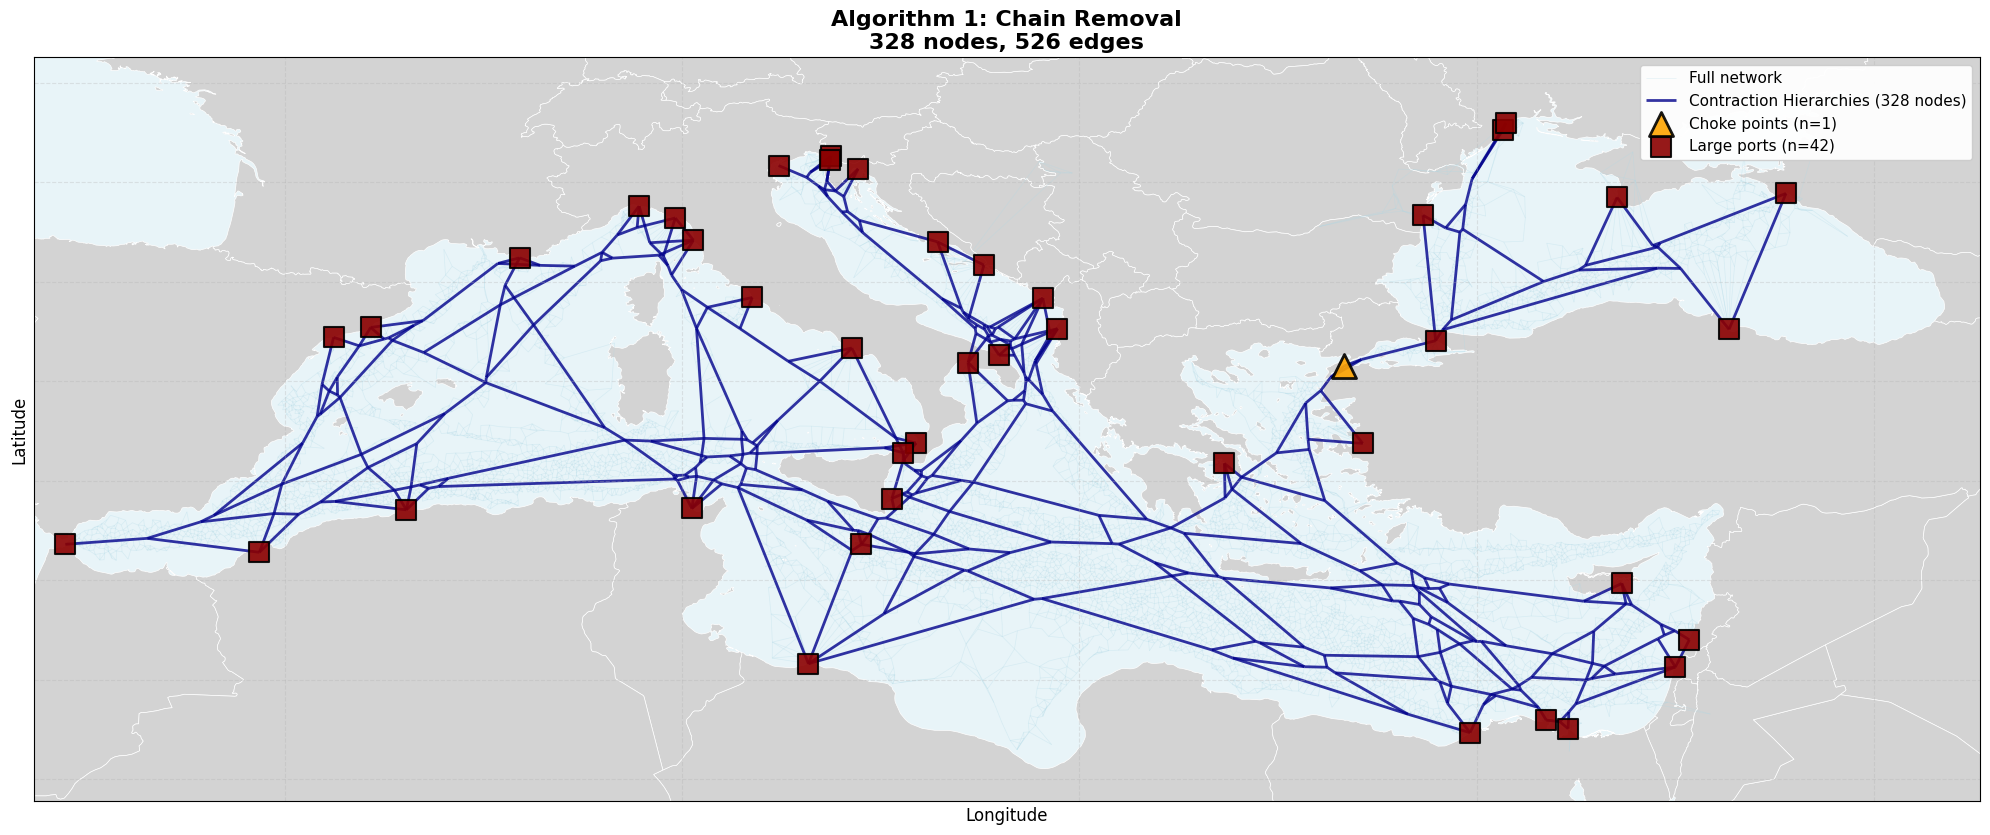


Contraction Hierarchies preserves:
  ✓ All ports
  ✓ All choke points
  ✓ All junctions (degree ≠ 2)
  ✓ Straight-line paths between them


In [25]:
# ALGORITHM 1: Contraction Hierarchies Simplification
print("="*80)
print("ALGORITHM 1: Contraction Hierarchies Simplification")
print("="*80)

# Contraction Hierarchies contracts degree-2 nodes by removing them
# and connecting their neighbors directly

G_ch = G_filtered.copy()

print(f"Starting graph: {G_ch.number_of_nodes()} nodes, {G_ch.number_of_edges()} edges")

# Iteratively contract degree-2 nodes that are not ports or choke points
contracted_count = 0
while True:
    # Find all degree-2 nodes that are not ports or choke points
    degree_2_nodes = [n for n in G_ch.nodes() 
                      if G_ch.degree(n) == 2 and G_ch.nodes[n].get('source') not in ['port', 'choke_point']]
    
    if not degree_2_nodes:
        break
    
    # Contract each degree-2 node
    for node in degree_2_nodes:
        neighbors = list(G_ch.neighbors(node))
        if len(neighbors) == 2:
            # Get the two neighbors
            n1, n2 = neighbors
            
            # Calculate new edge distance (sum of two edges being replaced)
            dist1 = G_ch.edges[node, n1]['distance']
            dist2 = G_ch.edges[node, n2]['distance']
            new_dist = dist1 + dist2
            
            # Add edge between the two neighbors
            if not G_ch.has_edge(n1, n2):
                G_ch.add_edge(n1, n2, distance=new_dist, source='contracted')
            
            # Remove the degree-2 node
            G_ch.remove_node(node)
            contracted_count += 1

print(f"Contracted {contracted_count} degree-2 nodes")
print(f"Final graph: {G_ch.number_of_nodes()} nodes, {G_ch.number_of_edges()} edges")
print(f"Reduction: {(1 - G_ch.number_of_nodes()/G_filtered.number_of_nodes())*100:.1f}% fewer nodes")

# Visualize
# Use original data extent for all maps
lon_min, lon_max = ORIGINAL_LON_MIN - 1, ORIGINAL_LON_MAX + 1
lat_min, lat_max = ORIGINAL_LAT_MIN - 1, ORIGINAL_LAT_MAX + 1

fig, ax = plt.subplots(figsize=(20, 16))
world.plot(ax=ax, color='lightgray', edgecolor='white', linewidth=0.5)
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

# Draw original network in light blue
pos_full = nx.get_node_attributes(G_with_ports, 'pos')
nx.draw_networkx_edges(G_with_ports, pos_full, ax=ax, 
                       edge_color='lightblue', width=0.5, alpha=0.3,
                       label='Full network')

# Draw simplified network in dark blue
pos_ch = nx.get_node_attributes(G_ch, 'pos')
nx.draw_networkx_edges(G_ch, pos_ch, ax=ax, 
                       edge_color='darkblue', width=2.0, alpha=0.8,
                       label=f'Contraction Hierarchies ({G_ch.number_of_nodes()} nodes)')

# Plot choke points
choke_point_nodes = [n for n in G_ch.nodes() if G_ch.nodes[n].get('source') == 'choke_point']
if choke_point_nodes:
    choke_lons = [G_ch.nodes[n]['lon'] for n in choke_point_nodes]
    choke_lats = [G_ch.nodes[n]['lat'] for n in choke_point_nodes]
    ax.scatter(choke_lons, choke_lats,
              c='orange', s=300, alpha=0.9,
              edgecolors='black', linewidths=2,
              label=f'Choke points (n={len(choke_point_nodes)})',
              zorder=11, marker='^')

# Plot ports
ax.scatter(large_ports['lon'], large_ports['lat'],
          c='darkred', s=200, alpha=0.9,
          edgecolors='black', linewidths=1.5,
          label=f'Large ports (n={len(large_ports)})',
          zorder=10, marker='s')

ax.grid(True, linestyle='--', alpha=0.3)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title(f'Algorithm 1: Chain Removal\n{G_ch.number_of_nodes()} nodes, {G_ch.number_of_edges()} edges', 
             fontsize=16, fontweight='bold')
ax.set_facecolor('#E8F4F8')
ax.legend(loc='upper right', fontsize=11, framealpha=0.95)
plt.tight_layout()
plt.show()

print(f"\nContraction Hierarchies preserves:")
print(f"  ✓ All ports")
print(f"  ✓ All choke points")
print(f"  ✓ All junctions (degree ≠ 2)")
print(f"  ✓ Straight-line paths between them")

In [26]:
# Add real-world lengths in kilometers to all edges in G_ch
print("="*80)
print("ADDING REAL-WORLD EDGE LENGTHS (KM)")
print("="*80)

from math import radians, cos, sin, asin, sqrt

def haversine_distance(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers
    r = 6371
    
    return c * r

print(f"Calculating real-world distances for {G_ch.number_of_edges()} edges...")

# Add length attribute to all edges
for u, v in tqdm(G_ch.edges(), desc="Calculating edge lengths"):
    # Get node coordinates
    lon1 = G_ch.nodes[u]['lon']
    lat1 = G_ch.nodes[u]['lat']
    lon2 = G_ch.nodes[v]['lon']
    lat2 = G_ch.nodes[v]['lat']
    
    # Calculate real-world distance in km
    length_km = haversine_distance(lon1, lat1, lon2, lat2)
    
    # Add as edge attribute
    G_ch.edges[u, v]['length'] = length_km

ADDING REAL-WORLD EDGE LENGTHS (KM)
Calculating real-world distances for 526 edges...


Calculating edge lengths: 100%|██████████| 526/526 [00:00<00:00, 191261.72it/s]


In [27]:
# Export the Contraction Hierarchies network for use in other cells
# The graph G_ch is now available globally and can be used in subsequent cells

print(f"Contraction Hierarchies network (G_ch) is ready for use:")
print(f"  Nodes: {G_ch.number_of_nodes()}")
print(f"  Edges: {G_ch.number_of_edges()}")
print(f"  Variable name: G_ch")
print(f"\nYou can now use G_ch in any subsequent cell!")

# Export to pickle (preserves everything including tuples)
print(f"\n--- Exporting Network ---")
import pickle
pickle_path = "network_outputs/network_contraction_hierarchies.gpickle"
with open(pickle_path, 'wb') as f:
    pickle.dump(G_ch, f)
print(f"✓ Exported to pickle: {pickle_path}")

# Print statistics
print(f"\nNetwork Statistics:")
print(f"  Port nodes: {sum(1 for n in G_ch.nodes() if G_ch.nodes[n].get('source') == 'port')}")
print(f"  Choke point nodes: {sum(1 for n in G_ch.nodes() if G_ch.nodes[n].get('source') == 'choke_point')}")
print(f"  Network nodes: {sum(1 for n in G_ch.nodes() if G_ch.nodes[n].get('source') not in ['port', 'choke_point'])}")

print(f"\n--- To Load in Mediterranean_Model.ipynb ---")
print(f"import pickle")
print(f"with open('{pickle_path}', 'rb') as f:")
print(f"    G_ch = pickle.load(f)")

print(f"\n--- Edge Attributes ---")
print(f"  distance: Geographic distance (degrees)")
print(f"  length: Real-world distance (kilometers)")
print(f"  source: Origin of the edge")

Contraction Hierarchies network (G_ch) is ready for use:
  Nodes: 328
  Edges: 526
  Variable name: G_ch

You can now use G_ch in any subsequent cell!

--- Exporting Network ---
✓ Exported to pickle: network_outputs/network_contraction_hierarchies.gpickle

Network Statistics:
  Port nodes: 42
  Choke point nodes: 1
  Network nodes: 285

--- To Load in Mediterranean_Model.ipynb ---
import pickle
with open('network_outputs/network_contraction_hierarchies.gpickle', 'rb') as f:
    G_ch = pickle.load(f)

--- Edge Attributes ---
  distance: Geographic distance (degrees)
  length: Real-world distance (kilometers)
  source: Origin of the edge


ALGORITHM 2: Douglas-Peucker Simplification
Found 328 junction/port nodes


Simplifying paths: 100%|██████████| 328/328 [00:00<00:00, 8711.85it/s]


Douglas-Peucker complete:
  Original: 3038 nodes, 3236 edges
  Simplified: 328 nodes, 526 edges
  Reduction: 89.2% fewer nodes


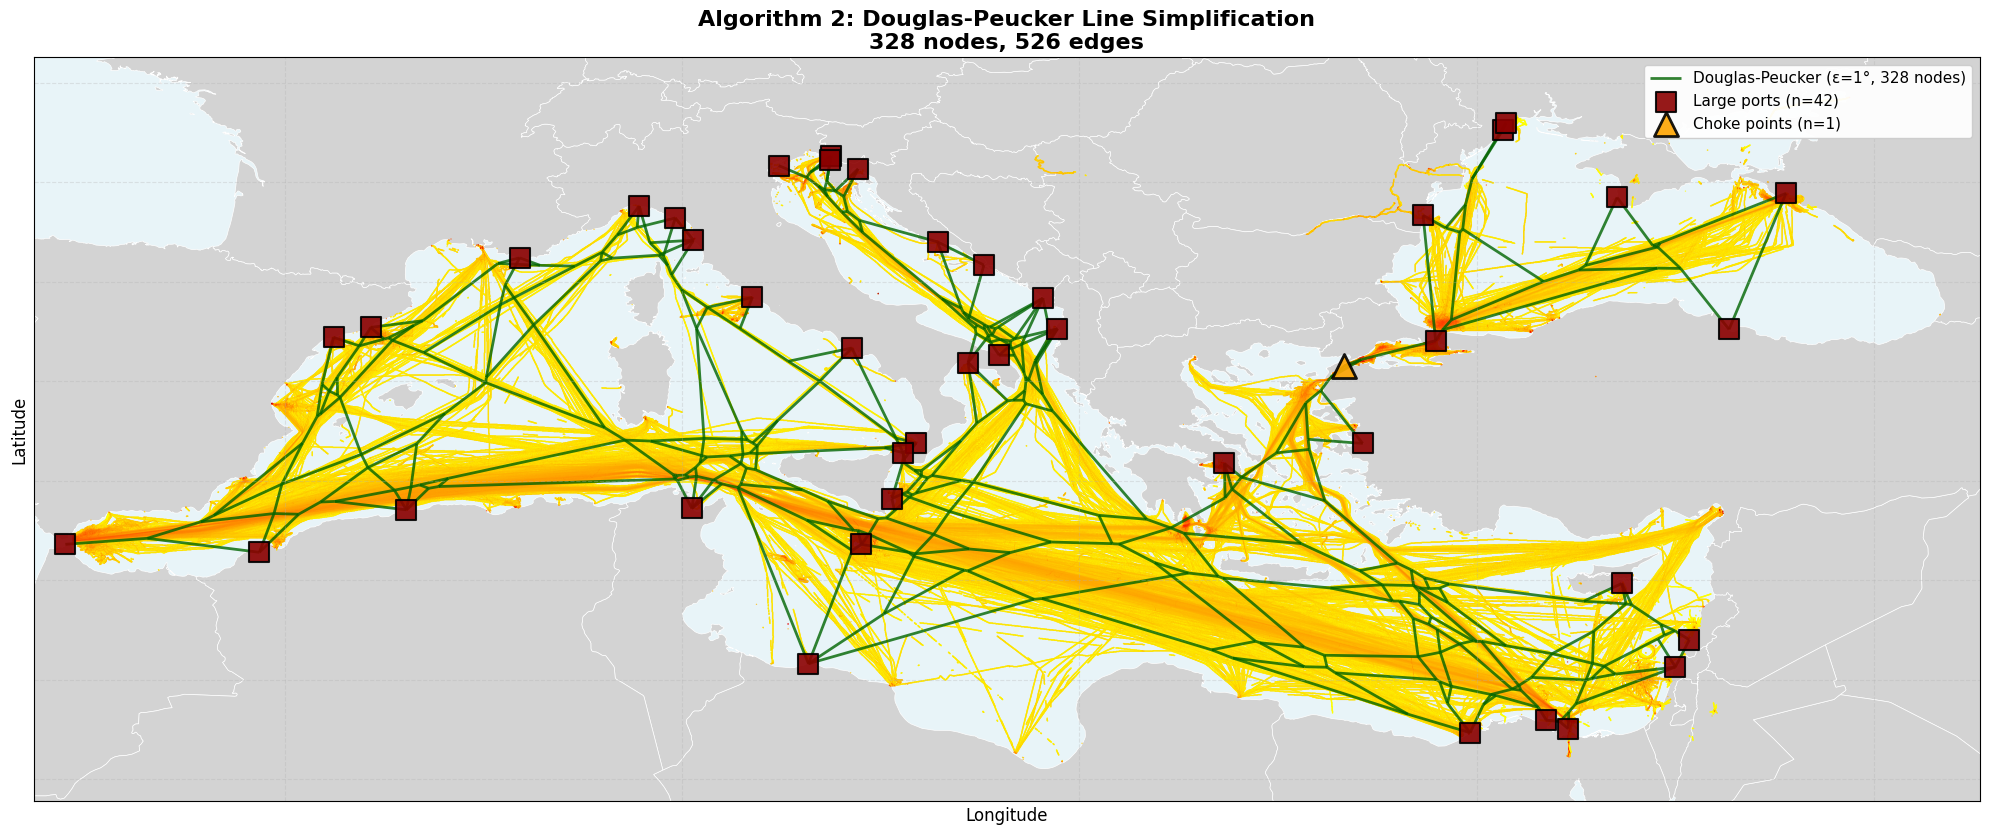

In [28]:
# ALGORITHM 2: Douglas-Peucker Simplification
print("="*80)
print("ALGORITHM 2: Douglas-Peucker Simplification")
print("="*80)

# Douglas-Peucker: Keep points where perpendicular distance from line exceeds epsilon
DOUGLAS_PEUCKER_EPSILON = 1  # degrees

def perpendicular_distance(point, line_start, line_end):
    """Calculate perpendicular distance from point to line segment"""
    px, py = point
    x1, y1 = line_start
    x2, y2 = line_end
    
    # Handle case where line_start == line_end
    if (x1 == x2) and (y1 == y2):
        return np.sqrt((px - x1)**2 + (py - y1)**2)
    
    # Calculate perpendicular distance
    num = abs((y2 - y1) * px - (x2 - x1) * py + x2 * y1 - y2 * x1)
    den = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    return num / den

def douglas_peucker_path(path_nodes, G, epsilon):
    """Apply Douglas-Peucker to a path of nodes"""
    if len(path_nodes) <= 2:
        return path_nodes
    
    # Get coordinates
    coords = [G.nodes[n]['pos'] for n in path_nodes]
    
    # Find point with maximum distance
    dmax = 0
    index = 0
    end = len(coords) - 1
    
    for i in range(1, end):
        d = perpendicular_distance(coords[i], coords[0], coords[end])
        if d > dmax:
            index = i
            dmax = d
    
    # If max distance is greater than epsilon, recursively simplify
    if dmax > epsilon:
        # Recursive call
        rec_results1 = douglas_peucker_path(path_nodes[:index+1], G, epsilon)
        rec_results2 = douglas_peucker_path(path_nodes[index:], G, epsilon)
        
        # Build the result list
        result = rec_results1[:-1] + rec_results2
    else:
        # Keep only endpoints
        result = [path_nodes[0], path_nodes[-1]]
    
    return result

# Apply Douglas-Peucker to each path between junctions/ports
G_dp = nx.Graph()

# First, identify junctions and ports (nodes to keep)
junction_nodes = set()
for node in G_filtered.nodes():
    if G_filtered.nodes[node].get('source') in ['port', 'choke_point'] or G_filtered.degree(node) != 2:
        junction_nodes.add(node)
        # Add to new graph
        G_dp.add_node(node, **G_filtered.nodes[node])

print(f"Found {len(junction_nodes)} junction/port nodes")

# For each junction, trace paths to next junction
processed_pairs = set()
for start_node in tqdm(junction_nodes, desc="Simplifying paths"):
    for neighbor in G_filtered.neighbors(start_node):
        # Trace path from start_node to next junction
        path = [start_node, neighbor]
        current = neighbor
        prev = start_node
        
        while current not in junction_nodes:
            # Find next node (not the previous one)
            next_nodes = [n for n in G_filtered.neighbors(current) if n != prev]
            if not next_nodes:
                break
            prev = current
            current = next_nodes[0]
            path.append(current)
        
        # Check if we've already processed this pair
        pair = frozenset([start_node, current])
        if pair in processed_pairs:
            continue
        processed_pairs.add(pair)
        
        # Apply Douglas-Peucker to the path
        simplified_path = douglas_peucker_path(path, G_filtered, DOUGLAS_PEUCKER_EPSILON)
        
        # Add simplified path nodes and edges
        for node in simplified_path[1:-1]:  # Exclude endpoints (already added)
            if node not in G_dp:
                G_dp.add_node(node, **G_filtered.nodes[node])
        
        # Add edges
        for i in range(len(simplified_path) - 1):
            n1, n2 = simplified_path[i], simplified_path[i+1]
            # Calculate distance
            pos1 = G_dp.nodes[n1]['pos']
            pos2 = G_dp.nodes[n2]['pos']
            dist = np.sqrt((pos2[0] - pos1[0])**2 + (pos2[1] - pos1[1])**2)
            G_dp.add_edge(n1, n2, distance=dist, source='simplified')

print(f"\nDouglas-Peucker complete:")
print(f"  Original: {G_filtered.number_of_nodes()} nodes, {G_filtered.number_of_edges()} edges")
print(f"  Simplified: {G_dp.number_of_nodes()} nodes, {G_dp.number_of_edges()} edges")
print(f"  Reduction: {(1 - G_dp.number_of_nodes()/G_filtered.number_of_nodes())*100:.1f}% fewer nodes")

# Visualize
# Use original data extent for all maps
lon_min, lon_max = ORIGINAL_LON_MIN - 1, ORIGINAL_LON_MAX + 1
lat_min, lat_max = ORIGINAL_LAT_MIN - 1, ORIGINAL_LAT_MAX + 1

fig, ax = plt.subplots(figsize=(20, 16))
world.plot(ax=ax, color='lightgray', edgecolor='white', linewidth=0.5)
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

# Use LogNorm for log-scale color mapping
norm = LogNorm(vmin=combined_data['value'].min()+0.01, vmax=combined_data['value'].max())

ax.scatter(combined_data['lon'], 
                     combined_data['lat'], 
                     c=combined_data['value'],
                     cmap=cmap,
                     norm=norm,
                     s=1,
                     alpha=0.7,
                     edgecolors='none')

# Draw simplified network in green
pos_dp = nx.get_node_attributes(G_dp, 'pos')
nx.draw_networkx_edges(G_dp, pos_dp, ax=ax, 
                       edge_color='darkgreen', width=2.0, alpha=0.8,
                       label=f'Douglas-Peucker (ε={DOUGLAS_PEUCKER_EPSILON}°, {G_dp.number_of_nodes()} nodes)')

# Plot ports
ax.scatter(large_ports['lon'], large_ports['lat'],
          c='darkred', s=200, alpha=0.9,
          edgecolors='black', linewidths=1.5,
          label=f'Large ports (n={len(large_ports)})',
          zorder=10, marker='s')


# Plot choke points
choke_point_nodes = [n for n in G_dp.nodes() if G_dp.nodes[n].get('source') == 'choke_point']
if choke_point_nodes:
    choke_lons = [G_dp.nodes[n]['lon'] for n in choke_point_nodes]
    choke_lats = [G_dp.nodes[n]['lat'] for n in choke_point_nodes]
    ax.scatter(choke_lons, choke_lats,
              c='orange', s=300, alpha=0.9,
              edgecolors='black', linewidths=2,
              label=f'Choke points (n={len(choke_point_nodes)})',
              zorder=11, marker='^')

ax.grid(True, linestyle='--', alpha=0.3)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title(f'Algorithm 2: Douglas-Peucker Line Simplification\n{G_dp.number_of_nodes()} nodes, {G_dp.number_of_edges()} edges', 
             fontsize=16, fontweight='bold')
ax.set_facecolor('#E8F4F8')
ax.legend(loc='upper right', fontsize=11, framealpha=0.95)
plt.tight_layout()
plt.show()

In [29]:
# Export final Contraction Hierarchies network
print("="*80)
print("EXPORTING FINAL NETWORK")
print("="*80)

output_file = "network_outputs/shipping_network_contraction_hierarchies.graphml"

# Create a copy of G_ch for export
G_export = G_ch.copy()

# Convert tuple attributes to strings for GraphML compatibility
print("Preparing graph for export...")
for node in G_export.nodes():
    if 'pos' in G_export.nodes[node]:
        # Convert pos tuple to string
        pos = G_export.nodes[node]['pos']
        G_export.nodes[node]['pos_str'] = f"{pos[0]},{pos[1]}"
        # Remove the tuple version
        del G_export.nodes[node]['pos']

# Export the graph
nx.write_graphml(G_export, output_file)

print(f"\n✓ Successfully exported Contraction Hierarchies network to: {output_file}")
print(f"\nNetwork Statistics:")
print(f"  Nodes: {G_export.number_of_nodes()}")
print(f"  Edges: {G_export.number_of_edges()}")
print(f"  Port nodes: {sum(1 for n in G_export.nodes() if G_export.nodes[n].get('source') == 'port')}")
print(f"  Choke point nodes: {sum(1 for n in G_export.nodes() if G_export.nodes[n].get('source') == 'choke_point')}")
print(f"  Network nodes: {sum(1 for n in G_export.nodes() if G_export.nodes[n].get('source') not in ['port', 'choke_point'])}")
print(f"  Average degree: {sum(dict(G_export.degree()).values()) / G_export.number_of_nodes():.2f}")
print(f"  Is connected: {nx.is_connected(G_export)}")

print(f"\n--- To Load This Network ---")
print(f"import networkx as nx")
print(f"G = nx.read_graphml('{output_file}')")
print(f"\n# Restore pos attribute from pos_str:")
print(f"for node in G.nodes():")
print(f"    if 'pos_str' in G.nodes[node]:")
print(f"        lon, lat = map(float, G.nodes[node]['pos_str'].split(','))")
print(f"        G.nodes[node]['pos'] = (lon, lat)")
print(f"\nThe network contains node attributes: lon, lat, source, pos_str")
print(f"The network contains edge attributes: distance, source")

EXPORTING FINAL NETWORK
Preparing graph for export...

✓ Successfully exported Contraction Hierarchies network to: network_outputs/shipping_network_contraction_hierarchies.graphml

Network Statistics:
  Nodes: 328
  Edges: 526
  Port nodes: 42
  Choke point nodes: 1
  Network nodes: 285
  Average degree: 3.21
  Is connected: True

--- To Load This Network ---
import networkx as nx
G = nx.read_graphml('network_outputs/shipping_network_contraction_hierarchies.graphml')

# Restore pos attribute from pos_str:
for node in G.nodes():
    if 'pos_str' in G.nodes[node]:
        lon, lat = map(float, G.nodes[node]['pos_str'].split(','))
        G.nodes[node]['pos'] = (lon, lat)

The network contains node attributes: lon, lat, source, pos_str
The network contains edge attributes: distance, source
